In [65]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

path = "/home/yaning/Documents/"
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=float('inf'))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open(path + "fire_data_10p_8f_non_zero.pkl", "rb") as f:
    fire_data = pickle.load(f)

In [4]:
fire_data = torch.tensor(fire_data, device=device)

Test Neurons with ion channels only

In [5]:
pixel_num = 10
feature_num = 8

Input neurons do not need detailed channels or receptors. 

**mp**: Membrane Potential  
**c**: Current

In [6]:
E_num = 20

In [7]:
base_tensor = torch.zeros(E_num, E_num)

Ion channels on the same neurons share the same gate values (m,n,h)

In [74]:
# initialise state values

m_states = base_tensor.clone()
m_states.fill_(0.061956531255774015)

n_states = base_tensor.clone()
n_states.fill_(0.3384883478113268)

h_states = base_tensor.clone()
h_states.fill_(0.5484107720738856)

initial_states = torch.stack([m_states, n_states, h_states], dim=0)

In [ ]:
def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states


In [ ]:
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

In [72]:
stim = np.zeros(pointCount)
stim[2000:2050] = 160

In [93]:
states = initial_states
mp = base_tensor.clone()
mp.fill_(1.3458754117369027)

voltages = []
for t in range(pointCount):
    inject_current = stim[t]

    sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
    potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
    leaky_currents = gMax_leaky*(mp-rE_leaky)

    ion_c = - sodium_currents - potassium_currents - leaky_currents + inject_current
    mp = mp + deltaTms*ion_c/Cm
    states = update_states(mp, states)

    voltages.append(mp[0][0]-70)

Add ligand gated receptos

In [105]:
# static parameters for ligand gated receptors
# parameters are in the order of AMPA, NMDA and GABA
gMax_ligands = torch.tensor([0.072, 0.0012, 0.004])

# the real values are below minors 70
rE_ligands = torch.tensor([70, 70, 140])

# below parameters are all guesses
u_se = torch.tensor([0.9, 0.9, 0.9])

tau_rec = torch.tensor([12, 12, 12])
tau_pre = torch.tensor([10, 10, 10])
tau_post = torch.tensor([20, 10, 10])
tau_decay = torch.tensor([8, 15, 20])
tau_rise = torch.tensor([10, 7, 7])

learning_rate = 0.7

In [ ]:
# three kinds of receptors
base_tensor = torch.zeros(3, E_num, E_num)

In [108]:
# all the dynamic parameters start with 1.
e = base_tensor.clone()
e.fill_(1)

w = base_tensor.clone()
w.fill_(1)

g_decay = base_tensor.clone()
g_decay.fill_(1)

g_rise = base_tensor.clone()
g_rise.fill_(1);

In [109]:
mp = base_tensor.clone()
mp.fill_(1.3458754117369027);

In [258]:
# receptor states active:1 and inactive:0
activeness = base_tensor.clone()
activeness.fill_(1.);

In [110]:
# arrays of having AMPA, NMDA and GABA receptor (1 is have, 0 is not)
# Q: should i use this or not, this slows it down but has more general use
have_AMPA = base_tensor.clone()
have_NMDA = base_tensor.clone()
have_GABA = base_tensor.clone()

In [111]:
have_AMPA.fill_(1)
have_NMDA.fill_(1);

In [266]:
def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + 1/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# deri as deriviation 
def e_deri(e, on_off):
    return (1-e)/tau_rec[:,None, None] - u_se[:,None,None]*on_off

def g_decay_deri(g_decay, w, e, on_off):
    return -g_decay/tau_decay[:,None,None] + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    return -g_rise/tau_rise[:,None,None] + w*e*on_off

In [120]:
tau_decay.shape

torch.Size([3])

In [262]:
# update e
e = runge_kutta(e_deri, e, deltaTms, activeness)

In [267]:
# update g_decay
g_decay = runge_kutta(g_decay_deri, g_decay, deltaTms*10, w, e, activeness)
g_rise = runge_kutta(g_rise_deri, g_rise, deltaTms*10, w, e, activeness)

In [269]:
gP = g_rise - g_decay

In [ ]:
def update_gP()

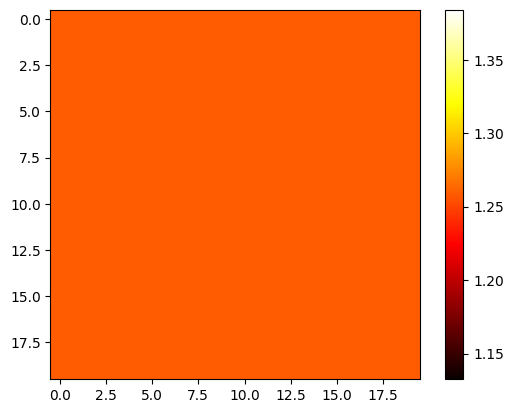

In [69]:
plt.imshow(mp, cmap='hot')
plt.colorbar() 
plt.show()